## Necessary Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import networkx as nx
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import warnings

## Importing the data

In [2]:
from torch_geometric.datasets import TUDataset
from torch_geometric.data import extract_zip
import os
import urllib.request
import shutil
        
warnings.filterwarnings('ignore')

np.random.seed(42)

print("="*70)
print("QUANTUM HACKATHON: MOLECULAR CLASSIFICATION ")
print("="*70)

print("\n[1] LOADING DATASETS...")

datasets = []
names = ["MUTAG","PROTEINS", "AIDS", "NCI1", "PTC_MR"]
for NAME in names:
    try:
        dataset = TUDataset(root=f'/tmp/{NAME}', name=NAME)
        datasets.append(dataset)
        print(f"✓ Dataset {NAME} loaded successfully")
        print(f"  - Number of graphs: {len(dataset)}")
        print(f"  - Number of classes: {dataset.num_classes}")
        print(f"  - Number of node features: {dataset.num_node_features}")
    except Exception as e:
        print(f"✗ Error loading dataset: {e}")
        raise
    
    

QUANTUM HACKATHON: MOLECULAR CLASSIFICATION 

[1] LOADING DATASETS...
✓ Dataset MUTAG loaded successfully
  - Number of graphs: 188
  - Number of classes: 2
  - Number of node features: 7
✓ Dataset PROTEINS loaded successfully
  - Number of graphs: 1113
  - Number of classes: 2
  - Number of node features: 3
✓ Dataset AIDS loaded successfully
  - Number of graphs: 2000
  - Number of classes: 2
  - Number of node features: 38
✓ Dataset NCI1 loaded successfully
  - Number of graphs: 4110
  - Number of classes: 2
  - Number of node features: 37
✓ Dataset PTC_MR loaded successfully
  - Number of graphs: 344
  - Number of classes: 2
  - Number of node features: 18


## converter from PyTorch geometric to network data

In [3]:
def pyg_to_networkx(data):
    """Convert PyTorch Geometric Data to NetworkX graph"""
    G = nx.Graph()
    
    for i in range(data.num_nodes):
        node_feat = data.x[i].numpy() if hasattr(data.x[i], 'numpy') else data.x[i]
        atom_type = np.argmax(node_feat)
        G.add_node(i, atom_type=int(atom_type), features=node_feat)
    
    edge_index = data.edge_index.numpy() if hasattr(data.edge_index, 'numpy') else data.edge_index
    for i in range(edge_index.shape[1]):
        src, dst = int(edge_index[0, i]), int(edge_index[1, i])
        if src < dst:
            if data.edge_attr is not None:
                edge_feat = data.edge_attr[i].numpy() if hasattr(data.edge_attr[i], 'numpy') else data.edge_attr[i]
                bond_type = int(np.argmax(edge_feat))
            else:
                bond_type = 0
            G.add_edge(src, dst, bond_type=bond_type)
    
    return G

In [4]:
graphs_arr = [[pyg_to_networkx(dataset[i]) for i in range(len(dataset))] for dataset in datasets]
labels_arr = [np.array([int(dataset[i].y) for i in range(len(dataset))]) for dataset in datasets]

for name, labels in zip(names, labels_arr):
    print(f"✓ {name} Dataset converted to NetworkX format")
    print(f"  - (class 1): {np.sum(labels == 1)} ({100*np.sum(labels==1)/len(labels):.1f}%)")
    print(f"  - (class 0): {np.sum(labels == 0)} ({100*np.sum(labels==0)/len(labels):.1f}%)")

print("\n[2] EXPLORATORY DATA ANALYSIS...")



✓ MUTAG Dataset converted to NetworkX format
  - (class 1): 125 (66.5%)
  - (class 0): 63 (33.5%)
✓ PROTEINS Dataset converted to NetworkX format
  - (class 1): 450 (40.4%)
  - (class 0): 663 (59.6%)
✓ AIDS Dataset converted to NetworkX format
  - (class 1): 1600 (80.0%)
  - (class 0): 400 (20.0%)
✓ NCI1 Dataset converted to NetworkX format
  - (class 1): 2057 (50.0%)
  - (class 0): 2053 (50.0%)
✓ PTC_MR Dataset converted to NetworkX format
  - (class 1): 152 (44.2%)
  - (class 0): 192 (55.8%)

[2] EXPLORATORY DATA ANALYSIS...


In [5]:
stats_dfs = []

for graphs, name, labels in zip(graphs_arr, names, labels_arr):
    print(f'_Dataset {name}_')
    stats = {
        'num_nodes': [], 'num_edges': [], 'avg_degree': [], 'density': [],
        'avg_clustering': [], 'diameter': [], 'avg_path_length': []
    }

    for G in graphs:
        stats['num_nodes'].append(G.number_of_nodes())
        stats['num_edges'].append(G.number_of_edges())
        stats['avg_degree'].append(2 * G.number_of_edges() / G.number_of_nodes() if G.number_of_nodes() > 0 else 0)
        stats['density'].append(nx.density(G))
        
        try:
            stats['avg_clustering'].append(nx.average_clustering(G))
        except:
            stats['avg_clustering'].append(0)
        
        try:
            if nx.is_connected(G):
                stats['diameter'].append(nx.diameter(G))
                stats['avg_path_length'].append(nx.average_shortest_path_length(G))
            else:
                stats['diameter'].append(0)
                stats['avg_path_length'].append(0)
        except:
            stats['diameter'].append(0)
            stats['avg_path_length'].append(0)

    stats_df = pd.DataFrame(stats)
    stats_df['label'] = labels
    
    stats_dfs.append(stats_df)

_Dataset MUTAG_
_Dataset PROTEINS_
_Dataset AIDS_
_Dataset NCI1_
_Dataset PTC_MR_


_Dataset MUTAG_

 GRAPH STATISTICS SUMMARY:
       num_nodes  num_edges  avg_degree   density  avg_clustering
label                                                            
0      13.936508  14.619048    2.089930  0.169006             0.0
1      19.944000  22.400000    2.238588  0.123056             0.0
✓ Saved EDA visualization to 'eda_distributions_MUTAG.png'
_Dataset PROTEINS_

 GRAPH STATISTICS SUMMARY:
       num_nodes  num_edges  avg_degree   density  avg_clustering
label                                                            
0      49.996983  94.055807    3.798391  0.142377        0.472652
1      22.940000  41.522222    3.640718  0.315012        0.575407
✓ Saved EDA visualization to 'eda_distributions_PROTEINS.png'
_Dataset AIDS_

 GRAPH STATISTICS SUMMARY:
       num_nodes  num_edges  avg_degree   density  avg_clustering
label                                                            
0      37.610000  40.242500    2.133856  0.073496        0.001794
1      10.213125  1

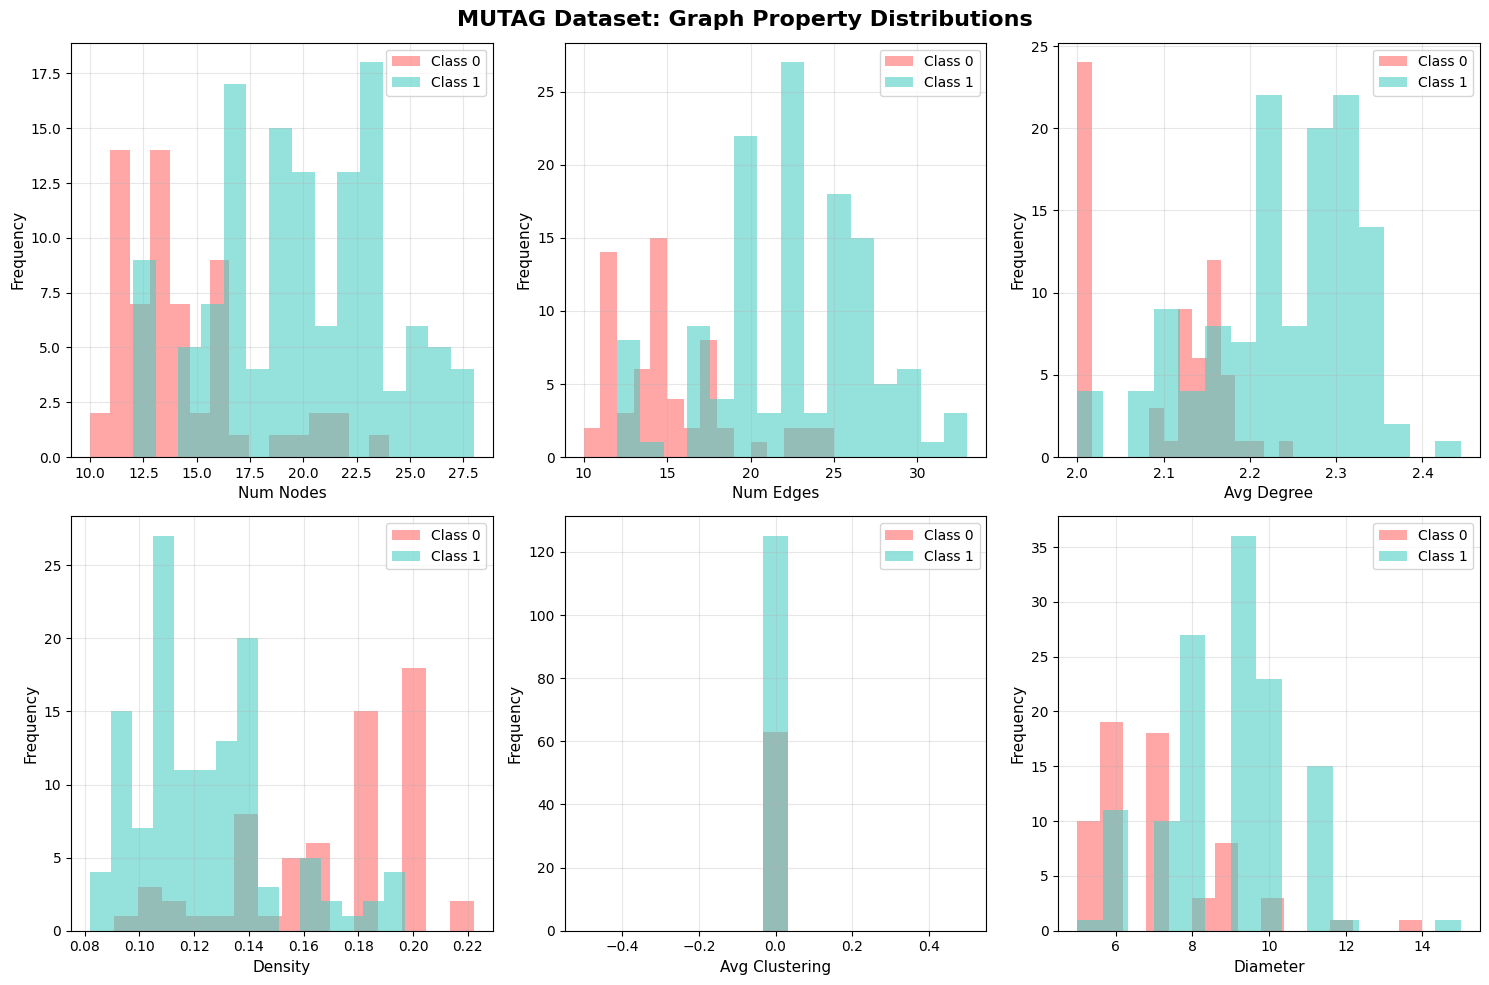

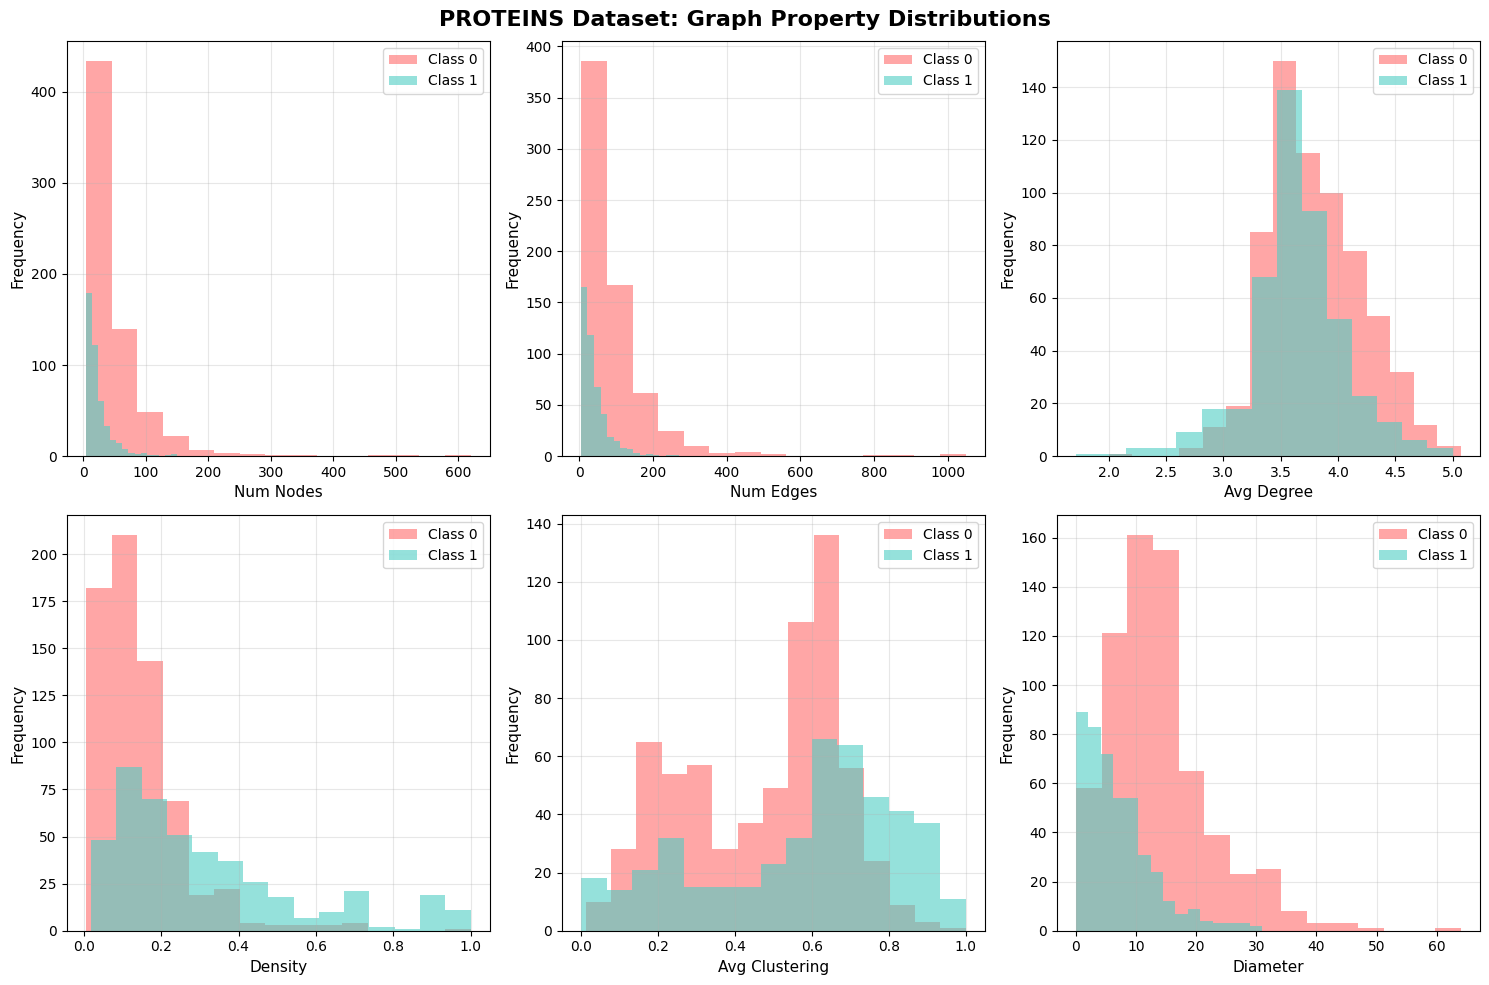

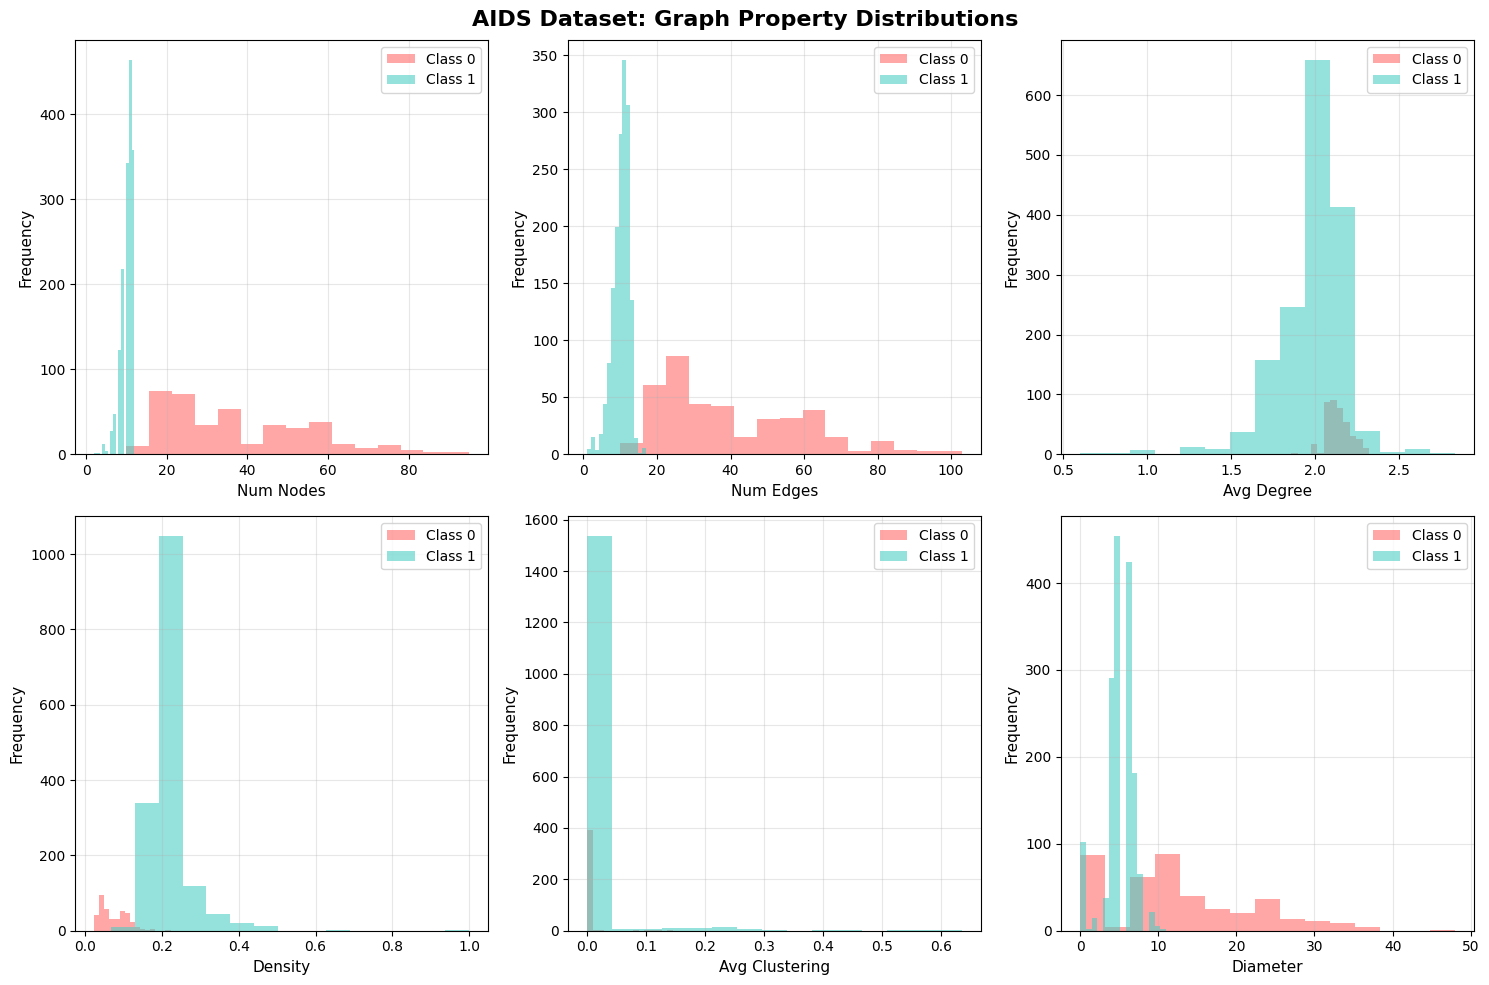

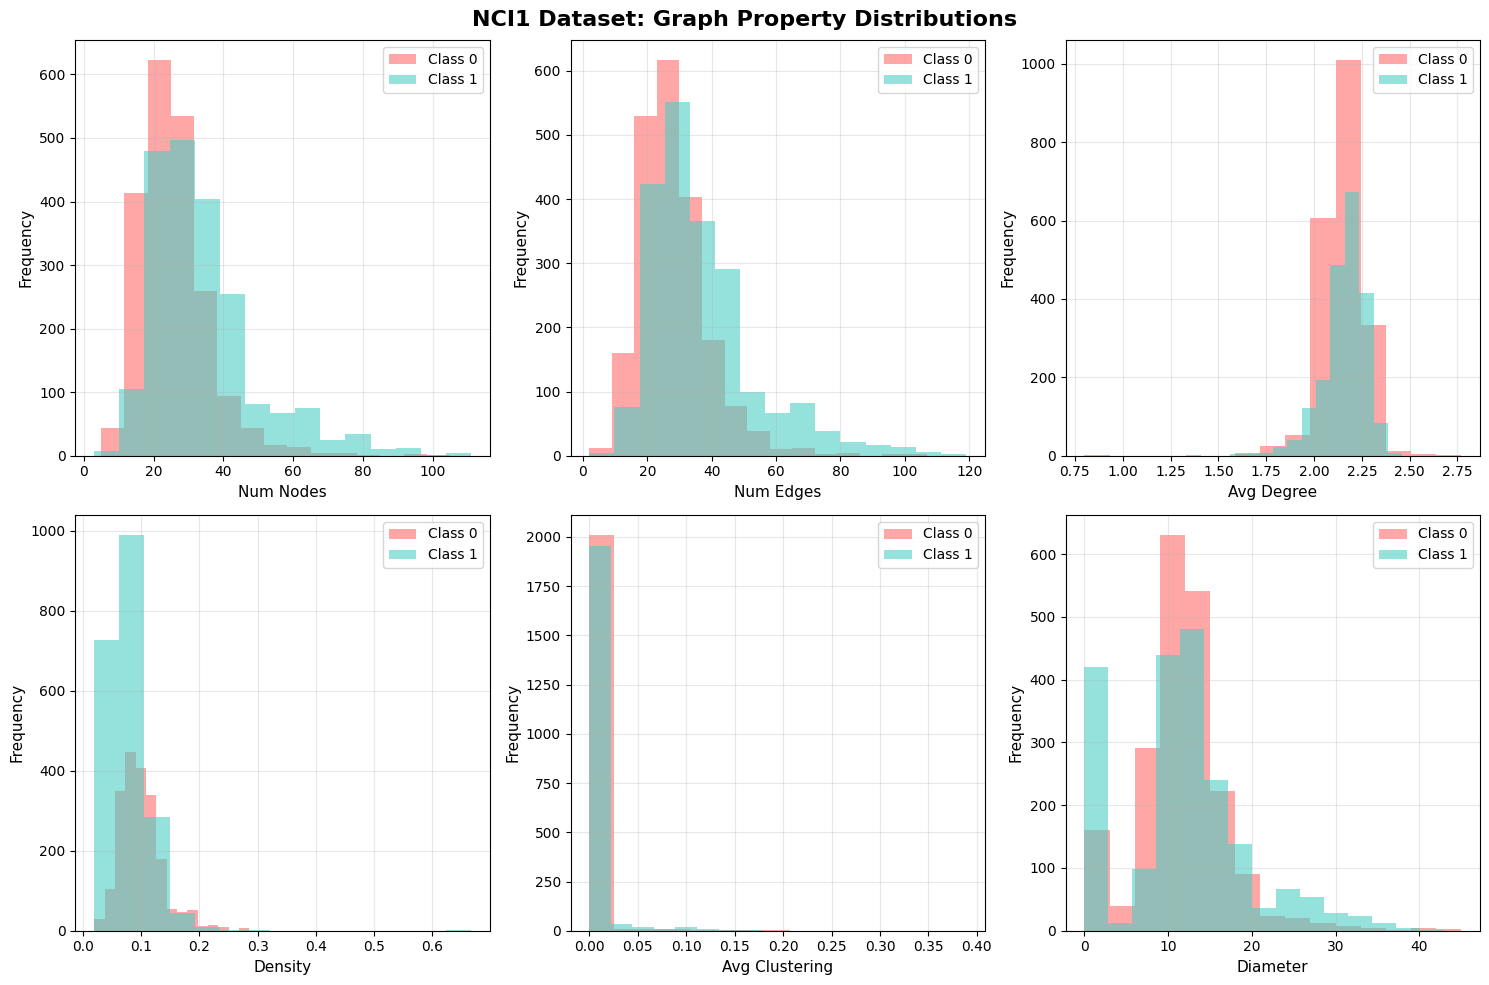

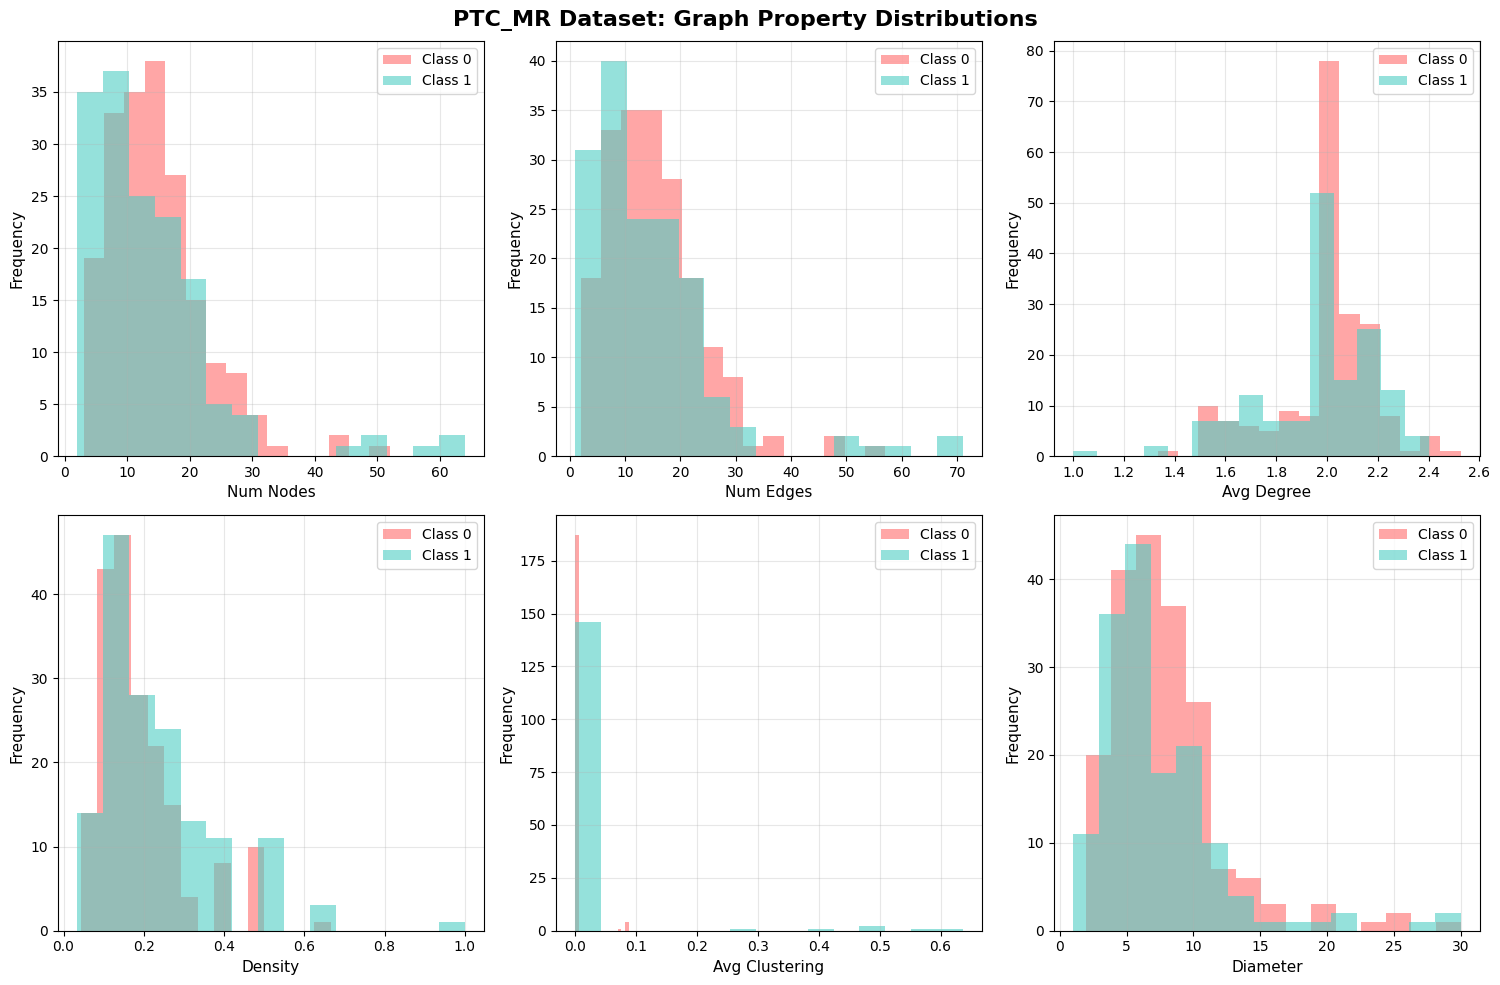

In [6]:
for stats_df, name in zip(stats_dfs, names):
    print(f'_Dataset {name}_')
    print("\n GRAPH STATISTICS SUMMARY:")
    print(stats_df.groupby('label')[['num_nodes', 'num_edges', 'avg_degree', 'density', 'avg_clustering']].mean())

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'{name} Dataset: Graph Property Distributions', fontsize=16, fontweight='bold')

    properties = ['num_nodes', 'num_edges', 'avg_degree', 'density', 'avg_clustering', 'diameter']
    colors = ['#FF6B6B', '#4ECDC4']

    for idx, prop in enumerate(properties):
        ax = axes[idx // 3, idx % 3]
        for label in [0, 1]:
            data = stats_df[stats_df['label'] == label][prop]
            ax.hist(data, alpha=0.6, label=f'Class {label}', bins=15, color=colors[label])
        ax.set_xlabel(prop.replace('_', ' ').title(), fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'eda_distributions_{name}.png', dpi=300, bbox_inches='tight')
    print(f'✓ Saved EDA visualization to \'eda_distributions_{name}.png\'')

In [7]:
atom_types_spec = [
    # MUTAG
    ['C', 'N', 'O', 'F', 'I', 'Cl', 'Br'], 
    # PROTEINS
    ['Helix', 'Sheet', 'Turn'],
    # AIDS
    ['C', 'O', 'N', '   Cl', 'F', 'S', 'Se', 'P', 'Na', 'I', 'Co', 'Br', 'Li', 'Si', 'Mg', 'Cu', 'As', 'B', 'Pt', 'Ru', 'K', 'Pd', 'Au', 'Te', 'W', 'Rh', 'Zn', 'Bi', 'Pb', 'Ge', 'Sb', 'Sn', 'Ga', 'Hg', 'Ho', 'Tl', 'Ni', 'Tb'], 
    # NCI1
    range(100), 
    # PTC_MR
    ['In', 'P', 'O', 'N', 'Na', 'C', 'Cl', 'S', 'Br', 'F', 'K', 'Cu', 'Zn', 'I', 'Ba', 'Sn', 'Pb', 'Ca' ]  
]

In [8]:
from collections import defaultdict

for name, graphs, atom_specs in zip(names, graphs_arr, atom_types_spec):
    print(f'Dataset {name}')
    atom_counts = defaultdict(int)

    for G in graphs:
        for node in G.nodes():
            atom_type = G.nodes[node]['atom_type']
            atom_counts[atom_specs[atom_type]] += 1

    print("\n ATOM TYPE DISTRIBUTION:")
    for atom_type in atom_counts:
        print(f"  {atom_type}: {atom_counts[atom_type]} ({100*atom_counts[atom_type]/sum(atom_counts.values()):.1f}%)")
    print('\n')

print("\n[3] FEATURE ENGINEERING - DESIGNING CUSTOM FEATURE MAP ")


Dataset MUTAG

 ATOM TYPE DISTRIBUTION:
  C: 2395 (71.0%)
  N: 345 (10.2%)
  O: 593 (17.6%)
  F: 12 (0.4%)
  I: 1 (0.0%)
  Cl: 23 (0.7%)
  Br: 2 (0.1%)


Dataset PROTEINS

 ATOM TYPE DISTRIBUTION:
  Helix: 21151 (48.7%)
  Sheet: 20931 (48.1%)
  Turn: 1389 (3.2%)


Dataset AIDS

 ATOM TYPE DISTRIBUTION:
  C: 19564 (62.3%)
  O: 5492 (17.5%)
  N: 4149 (13.2%)
     Cl: 385 (1.2%)
  F: 78 (0.2%)
  S: 1253 (4.0%)
  Se: 16 (0.1%)
  P: 109 (0.3%)
  Na: 60 (0.2%)
  I: 42 (0.1%)
  Co: 19 (0.1%)
  Br: 103 (0.3%)
  Li: 4 (0.0%)
  Si: 27 (0.1%)
  Mg: 1 (0.0%)
  Cu: 5 (0.0%)
  As: 7 (0.0%)
  B: 14 (0.0%)
  Pt: 13 (0.0%)
  Ru: 3 (0.0%)
  K: 6 (0.0%)
  Pd: 7 (0.0%)
  Au: 1 (0.0%)
  Te: 4 (0.0%)
  W: 1 (0.0%)
  Rh: 1 (0.0%)
  Zn: 3 (0.0%)
  Bi: 2 (0.0%)
  Pb: 1 (0.0%)
  Ge: 1 (0.0%)
  Sb: 1 (0.0%)
  Sn: 2 (0.0%)
  Ga: 2 (0.0%)
  Hg: 3 (0.0%)
  Ho: 1 (0.0%)
  Tl: 2 (0.0%)
  Ni: 2 (0.0%)
  Tb: 1 (0.0%)


Dataset NCI1

 ATOM TYPE DISTRIBUTION:
  0: 18267 (14.9%)
  1: 10279 (8.4%)
  2: 90287 (73.6%)
  3: 1

In [9]:
import networkx as nx
import numpy as np
from scipy.linalg import expm

In [11]:
from feature_map import QURIEnhancedMolecularFeatureMap

### 10 fold cross validation and final results

In [ ]:
for graphs, labels, name in zip(graphs_arr, labels_arr, names):
    print("="*30)
    print(f'Dataset {name}')
    print("="*30)
    
    print("Cross-Validation pipeline setup")

    # Create pipeline with feature extraction and scaling
    pipeline = Pipeline([
        ('features', QURIEnhancedMolecularFeatureMap(n_eigen=10, wl_iterations=3)),
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=1.0, gamma=0.1, random_state=42))
    ])

    kernels_config = {
        'Linear': {'svm__kernel': 'linear', 'svm__C': 1.0}
    }

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    results = {}

    for kernel_name, kernel_params in kernels_config.items():
        print(f"\n  Testing {kernel_name}...")
        
        pipeline.set_params(**kernel_params)
        
        cv_results = cross_validate(
            pipeline, graphs, labels,
            cv=cv,
            scoring=['accuracy', 'f1'],
            return_train_score=True
        )
        
        results[kernel_name] = {
            'train_accuracy': cv_results['train_accuracy'],
            'test_accuracy': cv_results['test_accuracy'],
            'test_f1': cv_results['test_f1'],
            'mean_train_acc': np.mean(cv_results['train_accuracy']),
            'mean_test_acc': np.mean(cv_results['test_accuracy']),
            'std_test_acc': np.std(cv_results['test_accuracy']),
            'mean_test_f1': np.mean(cv_results['test_f1']),
            'std_test_f1': np.std(cv_results['test_f1'])
        }
        
        print(f"    Accuracy: {results[kernel_name]['mean_test_acc']:.4f} ± {results[kernel_name]['std_test_acc']:.4f}")
        print(f"    F1-Score: {results[kernel_name]['mean_test_f1']:.4f} ± {results[kernel_name]['std_test_f1']:.4f}")

    print("\n[6] RESULTS ANALYSIS...")

    results_df = pd.DataFrame({
        'Kernel': list(results.keys()),
        'Accuracy': [results[k]['mean_test_acc'] for k in results.keys()],
        'Accuracy Std': [results[k]['std_test_acc'] for k in results.keys()],
        'F1-Score': [results[k]['mean_test_f1'] for k in results.keys()],
        'F1-Score Std': [results[k]['std_test_f1'] for k in results.keys()],
    })

    print("\n final results on  (10-Fold Cross-Validation):")
    print("="*70)
    print(results_df.to_string(index=False))
    print("="*70)

    best_kernel = results_df.loc[results_df['Accuracy'].idxmax(), 'Kernel']
    best_acc = results_df.loc[results_df['Accuracy'].idxmax(), 'Accuracy']
    best_f1 = results_df.loc[results_df['Accuracy'].idxmax(), 'F1-Score']

    print(f"\n KERNEL with best performance: {best_kernel}")
    print(f"  - Accuracy: {best_acc:.4f}")
    print(f"  - F1-Score: {best_f1:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('SVM Kernel Performance (10-Fold CV - Verified Fixed)', fontsize=14, fontweight='bold')

    x_pos = np.arange(len(results_df))
    axes[0].bar(x_pos, results_df['Accuracy'], yerr=results_df['Accuracy Std'], 
                color='steelblue', alpha=0.8, capsize=5)
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(results_df['Kernel'], rotation=45, ha='right')
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Classification Accuracy by Kernel', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0.85, color='red', linestyle='--', alpha=0.5, label='Target: 85%')
    axes[0].legend()

    fold_data = [results[k]['test_accuracy'] for k in results.keys()]
    bp = axes[1].boxplot(fold_data, labels=results_df['Kernel'], patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightcoral')
    axes[1].set_xticklabels(results_df['Kernel'], rotation=45, ha='right')
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Distribution Across Folds', fontsize=12)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('kernel_performance_verified_fixed.png', dpi=300, bbox_inches='tight')
    print("\n Saved performance visualization to 'kernel_performance_verified_fixed.png'")



Dataset MUTAG
Cross-Validation pipeline setup

  Testing Linear...
  ✓ Node attention initialized
  ✓ Edge attention initialized
  ✓ Feature map fitted on 169 graphs
  ✓ QURI Parts quantum simulation enabled
  ✓ Node attention initialized
  ✓ Edge attention initialized
  ✓ Feature map fitted on 169 graphs
  ✓ QURI Parts quantum simulation enabled
  ✓ Node attention initialized
  ✓ Edge attention initialized
  ✓ Feature map fitted on 169 graphs
  ✓ QURI Parts quantum simulation enabled
  ✓ Node attention initialized
  ✓ Edge attention initialized
  ✓ Feature map fitted on 169 graphs
  ✓ QURI Parts quantum simulation enabled
  ✓ Node attention initialized
  ✓ Edge attention initialized
  ✓ Feature map fitted on 169 graphs
  ✓ QURI Parts quantum simulation enabled
  ✓ Node attention initialized
  ✓ Edge attention initialized
  ✓ Feature map fitted on 169 graphs
  ✓ QURI Parts quantum simulation enabled
  ✓ Node attention initialized
  ✓ Edge attention initialized
  ✓ Feature map fitted on